# Imports

In [2]:
import numpy as np
import pandas as pd
import nltk
from textblob import TextBlob
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import spacy
from collections import defaultdict
import matplotlib.pyplot as plt
import re
import ast
# import json
import pickle

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Horstann\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Horstann\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Horstann\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def to_pkl(data, filename):
    file = open(filename, 'wb') 
    pickle.dump(data, file)

def from_pkl(filename):
    file = open(filename, 'rb') 
    return pickle.load(file)

# def to_json(data, file)
#     str_data = {str(key): value for key, value in data.items()}
#     with open(file, 'w') as file:
#         json.dump(data, file)

# def from_json(file):
#     with open(file, 'r') as file:
#         str_data = json.load(file)
#     data = {ast.literal_eval(key): value for key, value in str_data.items()}
#     return data

# Data Preprocessing

## Cleaning

In [119]:
df_130k = pd.read_csv('winemag-data-130k-v2.csv')
df_150k = pd.read_csv('winemag-data_first150k.csv')

# Merge datasets
df = pd.concat([df_130k, df_150k]).drop(columns=['Unnamed: 0'])
df = df[~df.duplicated()].reset_index(drop=True)
df.index.name = 'index'
# Save df
df.to_csv('01_winemag-data.csv')

In [133]:
df = pd.read_csv('01_winemag-data.csv', index_col='index')
# Remove duplicates
df = df[~df.description.duplicated()].reset_index(drop=True)
df.index.name = 'index'
# Save df
df.to_csv('01_winemag-data.csv')

## Sentence Segmentation

In [83]:
df = pd.read_csv('01_winemag-data.csv', index_col='index')

In [117]:
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
punctuations = string.punctuation.replace('_', '')
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")

def merge_negations(text):
    blob = TextBlob(text)
    tokens = blob.words
    new_tokens = []
    skip_next = False
    
    for i, token in enumerate(tokens):
        # Skip this token if it's already combined
        if skip_next:
            skip_next = False
            continue
        # If this token is "not" or "n't", combine it with the next token
        if token == "not" or token == "n't":
            try: 
                combined_token = f"not_{tokens[i+1]}"
                new_tokens.append(combined_token)
                skip_next = True
            except:
                print(text)
                print(tokens)
                return float('nan')
        else:
            new_tokens.append(token)
    return ' '.join(new_tokens)

def process_text(text):
    # Merge negations
    # text = merge_negations(text)
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Keep only nouns and adjectives
    doc = nlp(text)
    text = ' '.join([token.text for token in doc if token.pos_ in ['NOUN', 'ADJ']])
    # Remove punctuation
    text = ''.join([char for char in text if char not in punctuations])
    # Tokenize text
    words = word_tokenize(text)
    # Remove stop words and stem remaining words
    words = [lemmatizer.lemmatize(word.lower()) for word in words if (word.lower() not in stop_words and len(word)>2)]
    return list(set(words))

In [ ]:
df['words'] = df['description'].apply(process_text)

In [138]:
df.to_csv('02_winemag-data-tokenized.csv')

## Reducing number of items

Some adjectives or nouns don't give any meaningful description to wines, or are used very occasionally. So we try to remove these words, which improves Apriori's runtime too since we have a lot of words. 

In [16]:
df = pd.read_csv('02_winemag-data-tokenized.csv', index_col='index')
df = df[~df.words.isna()]
df.words = df.words.map(ast.literal_eval)

In [ ]:
words_count = defaultdict(int)
for words in df.words:
    for word in words:
        words_count[word] += 1

words_prob = defaultdict(int)
for word in words_count.keys():
    words_prob[word] = words_count[word] / len(df)

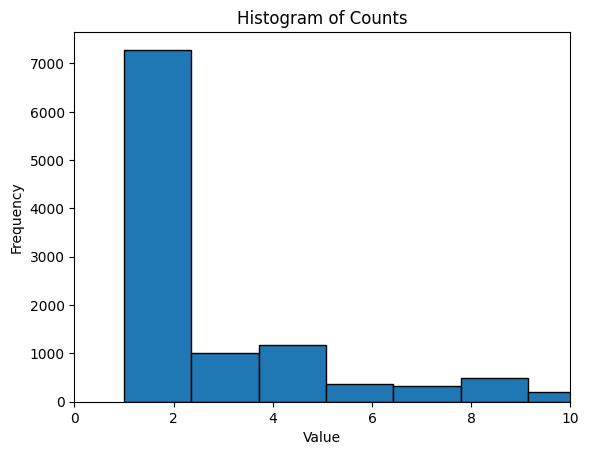

In [ ]:
# Plot histogram
plt.hist(words_count.values(), bins='auto', edgecolor='black')
plt.title("Histogram of Counts")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Show the plot
plt.xlim(0,10)
plt.show()

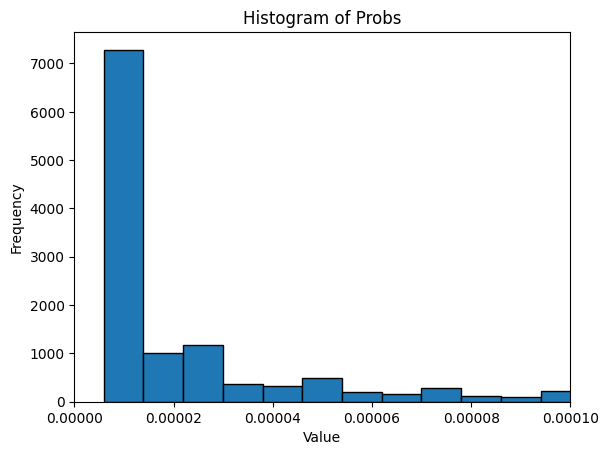

In [ ]:
# Plot histogram
plt.hist(words_prob.values(), bins='auto', edgecolor='black')
plt.title("Histogram of Probs")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Show the plot
plt.xlim(0,0.0001)
plt.show()

In [ ]:
print(len(words_prob))
print(len(df))

15733
169461


In [ ]:
upper_bound = 0.5
lower_bound = 1e-3

In [ ]:
vocab_size = len(words_prob)
words_to_ignore = defaultdict(int)

for word in words_prob.keys():
    if words_prob[word]<lower_bound or words_prob[word]>upper_bound: 
        vocab_size -= 1
        words_to_ignore[word] = words_count[word]

other_words_to_ignore = ['palate', 'nose', 'year', 'aroma', 'note', 'finish']
for word in other_words_to_ignore:
    words_to_ignore[word] = words_count[word]
    vocab_size -= 1

def update_words(words):
    remaining_words = []
    for word in words:
        if not words_to_ignore[word]:
            del words_to_ignore[word]
            remaining_words.append(word)
    return remaining_words

df.words = df.words.apply(update_words)
print(vocab_size)
remaining_rows = len([1 for x in df.words.values.tolist() if x != []])
print(remaining_rows)
display(words_to_ignore)

1405
169451


defaultdict(int,
            {'unripened': 3,
             'brimstone': 75,
             'wine': 86379,
             'dominate': 98,
             'flavor': 86215,
             'semidry': 85,
             'winter': 123,
             'unfussy': 37,
             'horseradish': 37,
             'profusion': 20,
             'footprint': 13,
             'sunnier': 3,
             'sprightly': 101,
             'envelope': 42,
             'accessibility': 30,
             'reduced': 84,
             'abrupt': 112,
             'trend': 53,
             'generation': 138,
             'buttercream': 128,
             'vinegar': 143,
             'set': 164,
             'respectable': 60,
             'bolt': 24,
             'desiccated': 19,
             'pervade': 35,
             'levity': 32,
             'district': 42,
             'fettuccine': 8,
             'commendable': 65,
             'designates': 58,
             'greener': 57,
             'powdery': 139,
             'bea

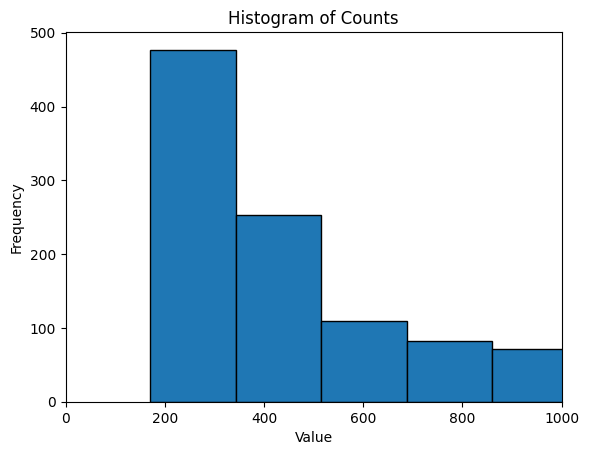

In [ ]:
words_count = defaultdict(int)
for words in df.words:
    for word in words:
        words_count[word] += 1

words_prob = defaultdict(int)
for word in words_count.keys():
    words_prob[word] = words_count[word] / len(df)

# Plot histogram
plt.hist(words_count.values(), bins='auto', edgecolor='black')
plt.title("Histogram of Counts")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Show the plot
plt.xlim(0,1000)
plt.show()

In [20]:
# Remove rows where there are no items
df = df[[len(words)>0 for words in df.words]]

In [23]:
df.to_csv('03_winemag-data-reduced.csv')

: 

# FP-growth

In [4]:
df = pd.read_csv('03_winemag-data-reduced.csv', index_col='index')
df.words = df.words.map(ast.literal_eval)

In [13]:
transactions = df.words.values.tolist()

In [11]:
MIN_SUPPORT = 0.025

## Built-In Package

In [6]:
from apyori import apriori
import pyfpgrowth

Note that `pyfpgrowth` has some discrepancies. Eg. it may list (X,Y) as a frequent pattern, but not (X).
https://github.com/evandempsey/fp-growth/issues/6

In [15]:
# patterns = pyfpgrowth.find_frequent_patterns(transactions, support_threshold=MIN_SUPPORT*len(transactions))
# frequent_itemsets1 = [(frozenset(itemset), count/len(transactions)) for itemset, count in patterns.items()]
frequent_itemsets1 = list(apriori(transactions, min_support=MIN_SUPPORT))
display(frequent_itemsets1)
print(len(frequent_itemsets1))

[RelationRecord(items=frozenset({'acid'}), support=0.030952900838590508, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'acid'}), confidence=0.030952900838590508, lift=1.0)]),
 RelationRecord(items=frozenset({'acidity'}), support=0.24233554242819458, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'acidity'}), confidence=0.24233554242819458, lift=1.0)]),
 RelationRecord(items=frozenset({'alcohol'}), support=0.026343898826209345, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'alcohol'}), confidence=0.026343898826209345, lift=1.0)]),
 RelationRecord(items=frozenset({'apple'}), support=0.09527237962596857, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'apple'}), confidence=0.09527237962596857, lift=1.0)]),
 RelationRecord(items=frozenset({'attractive'}), support=0.026963546984083896, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_

236


In [ ]:
rules = pyfpgrowth.generate_association_rules(frequent_itemsets1, confidence_threshold=0.7)
display(rules)
print(len(rules))

In [35]:
# to_pkl(frequent_itemsets1, 'frequent_itemsets1.pkl')
to_pkl(rules, 'rules.pkl')

## Implementation from Scratch

As per the project guidelines, this section only implements the algorithm to produce the `frequent_itemsets`, but not the `rules`.

In [19]:
# FP Tree Class
class Node:
    def __init__(self, item, count, parent):
        self.item = item
        self.count = count
        self.parent = parent
        self.children = {} # Maps item name to Node's child object
        self.next_node = None
        self.link = None

    def add_child(self, child):
        if child.item not in self.children:
            self.children[child.item] = child

    def increment_count(self, count):
        self.count += count

    def get_nodes_with_item(self, item):
        nodes = []
        if self.item == item:
            nodes.append(self)
        for child in self.children.values():
            nodes.extend(child.get_nodes_with_item(item))
        return nodes

class FPTree:
    def __init__(self):
        self.root = Node("*", 0, None)
        self.header_table = {} # Maps item name to Node object

    def add_transaction(self, transaction):
        current_node = self.root
        for item in transaction:
            # Get child node as node for current item
            child_node = current_node.children.get(item)
            # If child node is None, initialise it
            if child_node is None:
                child_node = Node(item, 0, current_node)
                current_node.children[item] = child_node
                # Connect header table to child node
                if item in self.header_table:
                    last_node = self.header_table[item]
                    while last_node.link is not None:
                        last_node = last_node.link
                    last_node.link = child_node
                else:
                    self.header_table[item] = child_node
            # Increment child node's count
            child_node.increment_count(1)
            # Go 1 level deeper into the tree for next item
            current_node = child_node

    def get_frequent_items(self, min_support):
        """Get individual items which sum of counts reach min_support"""
        frequent_items = {}
        for item in self.header_table:
            support = 0
            node = self.header_table[item]
            while node is not None:
                support += node.count
                node = node.link
            if support >= min_support:
                frequent_items[item] = support
        return frequent_items
    
    def get_nodes_with_item(self, item):
        return self.header_table.get(item, [])

In [20]:
# fp-growth
class FP_Growth():
    def __init__(self, transactions, min_support=0.1, min_confidence=0.5):
        self.transactions = transactions
        self.min_support = min_support
        # self.min_confidence = min_confidence
        self.num_transactions = len(transactions)
        self.num_min_support = self.min_support * self.num_transactions
        self.frequent_itemsets = []
        self.ordered_frequent_items = []
        self.ordered_itemsets = []

    def _get_frequent_items(self, transactions=None, order=False):
        if not transactions: transactions = self.transactions
        items_count = defaultdict(int)
        for transaction in transactions:
            for item in transaction:
                items_count[item] += 1

        # Filter frequent 1-itemsets
        frequent_items = [(item, count) for item, count in items_count.items() if count >= self.num_min_support]
        if order:
            # Sort  frequent 1-itemsets by their support
            frequent_items = sorted(frequent_items, key=lambda x: x[1], reverse=True)
        
        frequent_items = [item for item, count in frequent_items]
        return frequent_items

    def _generate_ordered_itemsets(self):
        self.ordered_frequent_items = self._get_frequent_items(order=True)

        is_frequent = defaultdict(int)
        for item in self.ordered_frequent_items:
            is_frequent[item] = 1
        # For each transaction, get items only present in self.ordered_frequent_items
        unordered_itemsets = []
        for transaction in self.transactions:
            items = []
            for item in transaction:
                if is_frequent[item]:
                    items.append(item)
            unordered_itemsets.append(items)
        
        # Sort items by order which they appear in self.ordered_frequent_items
        self.ordered_itemsets = []
        for transaction in unordered_itemsets:
            new_transaction = []
            for item in self.ordered_frequent_items:
                if item in transaction:
                    new_transaction.append(item)
            self.ordered_itemsets.append(new_transaction)

    def _generate_fptree(self, transactions=None):
        if not transactions: transactions = self.transactions.copy()
        self.fptree = FPTree()
        for transaction in self.ordered_itemsets:
            self.fptree.add_transaction(transaction)

    def print_tree(self, node=None, indent_times=0):
        if not node:
            node = self.fptree.root
        indent = "    " * indent_times
        print ("%s%s:%s" % (indent, node.item, node.count))
        for child_key in node.children:
            child = node.children[child_key]
            self.print_tree(child, indent_times + 1)

    def _extract_patterns_from_tree(self, tree):
        """Extract frquent patterns from given fptree"""
        if tree is None: return []

        frequent_patterns = []
        frequent_items = tree.get_frequent_items(self.num_min_support)
        
        for item, count in frequent_items.items():
            # Get base pattern
            base_pattern = [(item, count)]
            # Get conditional patterns
            conditional_pattern_base = self._get_conditional_pattern_base(tree, item)
            # Construct conditional fptree based on conditional patterns
            conditional_tree = self._generate_conditional_fptree(conditional_pattern_base)
            # Recursively mine conditional fptree
            conditional_patterns = self._extract_patterns_from_tree(conditional_tree)
            
            # Add patterns to result
            frequent_patterns.append(base_pattern)
            for pattern in conditional_patterns:
                frequent_patterns.append(base_pattern + pattern)
                
        return frequent_patterns

    def _get_conditional_pattern_base(self, tree, item):
        """ 
        Get patterns that end with the given item 
        Returns a list, where each element of tuples (item, count)
        """
        conditional_pattern_base = []
        node = tree.header_table[item]
        while node is not None:
            pattern = []
            parent = node.parent
            # Traverse from item to root
            while parent.item != "*":
                pattern.append((parent.item, node.count))
                parent = parent.parent
            if pattern: conditional_pattern_base.append(pattern)
            node = node.link
        return conditional_pattern_base 
    
    def _generate_conditional_fptree(self, conditional_pattern_base):
        """Generate fptree given a list of patterns"""
        tree = FPTree()
        for pattern in conditional_pattern_base:
            for _ in range(pattern[0][1]):
                # Only take the items (not counts) for adding a transaction
                transaction = [item[0] for item in pattern]
                tree.add_transaction(transaction)
        return tree#, tree.get_frequent_items(self.num_min_support)

    def run(self, show_tree=False):
        self._generate_ordered_itemsets()
        self._generate_fptree()

        if show_tree:
            print ("FP-Growth Tree:")
            self.print_tree()
            print()

        # Mine frequent itemsets from fptree
        frequent_patterns = self._extract_patterns_from_tree(self.fptree)
        for pattern in frequent_patterns:
            itemset = []
            support = self.num_transactions
            for item, count in pattern:
                itemset.append(item)
                support = min(support, count)
            itemset = frozenset(itemset)
            self.frequent_itemsets.append((itemset, count/self.num_transactions))
        
        return self.frequent_itemsets

In [24]:
fp_growth = FP_Growth(transactions, min_support=MIN_SUPPORT)
frequent_itemsets = fp_growth.run(show_tree=False)
display(frequent_itemsets)
print(len(frequent_itemsets))

[(frozenset({'fruit'}), 0.4237095089435884),
 (frozenset({'acidity'}), 0.24233554242819458),
 (frozenset({'acidity', 'fruit'}), 0.10765944137243215),
 (frozenset({'acidity', 'cherry', 'fruit'}), 0.012977202849201244),
 (frozenset({'acidity', 'cherry'}), 0.04496875202861004),
 (frozenset({'apple'}), 0.09527237962596857),
 (frozenset({'acidity', 'apple'}), 0.032923972121734306),
 (frozenset({'apple', 'fruit'}), 0.03077585850776921),
 (frozenset({'acidity', 'apple', 'fruit'}), 0.010935314633728925),
 (frozenset({'apple', 'fresh'}), 0.020070698904107974),
 (frozenset({'apple', 'dry'}), 0.014594189470702445),
 (frozenset({'apple', 'ripe'}), 0.017267528666104065),
 (frozenset({'citrus'}), 0.08051295064649958),
 (frozenset({'apple', 'citrus'}), 0.019675304365273736),
 (frozenset({'acidity', 'citrus'}), 0.02389481324984804),
 (frozenset({'citrus', 'fruit'}), 0.034954057515151876),
 (frozenset({'acidity', 'citrus', 'fruit'}), 0.011088751320440718),
 (frozenset({'citrus', 'crisp'}), 0.0156446406

1060


Notice that we have a slightly larger output size than when we used the built-in package `pyfpgrowth`. There seems to be some missing itemsets in `pyfpgrowth`'s output.

In [41]:
to_pkl(frequent_itemsets, 'frequent_itemsets.pkl')